In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [5]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=range(2006, 2021),
    time_group='4h',
    price_calculation='close',
)

In [6]:
environment_columns = ['price', 'RSI_14', 'ATR_7', 'ADX_7_14']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [7]:
price_data = add_features(price_data.copy())

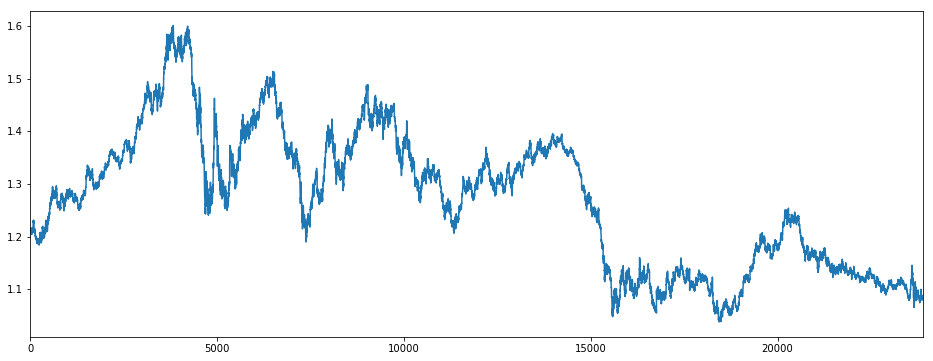

In [8]:
price_data['price'].plot(figsize=(16,6))

In [9]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 15927, test size 7964


In [10]:
episode=1000
batch_size=10

In [11]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,ATR_7,ADX_7_14
0,0,2006-01-05 00:00:00,1.21006,1.21220,1.20940,1.21100,1.21006,0.873589,0.004427,0.763987
1,1,2006-01-05 04:00:00,1.20948,1.21138,1.20838,1.21016,1.20948,0.806227,0.004070,0.649122
2,2,2006-01-05 08:00:00,1.20852,1.21108,1.20668,1.20948,1.20852,0.702112,0.004152,0.553291
3,3,2006-01-05 12:00:00,1.20920,1.21080,1.20760,1.20852,1.20920,0.702112,0.003914,0.499426
4,4,2006-01-05 16:00:00,1.21100,1.21160,1.20850,1.20920,1.21100,0.724409,0.003710,0.454017


In [12]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [13]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: -2693 pips, median trade count: 1598
....................
episode: 40/1000
median profit: -1742 pips, median trade count: 1395
....................
episode: 60/1000
median profit: -1742 pips, median trade count: 1249
....................
episode: 80/1000
median profit: -1742 pips, median trade count: 1212
....................
episode: 100/1000
median profit: -1742 pips, median trade count: 1202
....................
episode: 120/1000
median profit: -1622 pips, median trade count: 1179
....................
episode: 140/1000
median profit: -1487 pips, median trade count: 1128
....................
episode: 160/1000
median profit: -1608 pips, median trade count: 1121
....................
episode: 180/1000
median profit: -1588 pips, median trade count: 1058
....................
episode: 200/1000
median profit: -1425 pips, median trade count: 1041
....................
episode: 220/1000
median profit: -1272 pips, median trade count: 1028
.

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


...........
episode: 900/1000
median profit: 32 pips, median trade count: 933
...................

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


.
episode: 920/1000
median profit: 32 pips, median trade count: 933
....................
episode: 940/1000
median profit: 64 pips, median trade count: 930
....................
episode: 960/1000
median profit: 80 pips, median trade count: 926
....................
episode: 980/1000
median profit: 80 pips, median trade count: 925
.............

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


.......
episode: 1000/1000
median profit: 64 pips, median trade count: 921


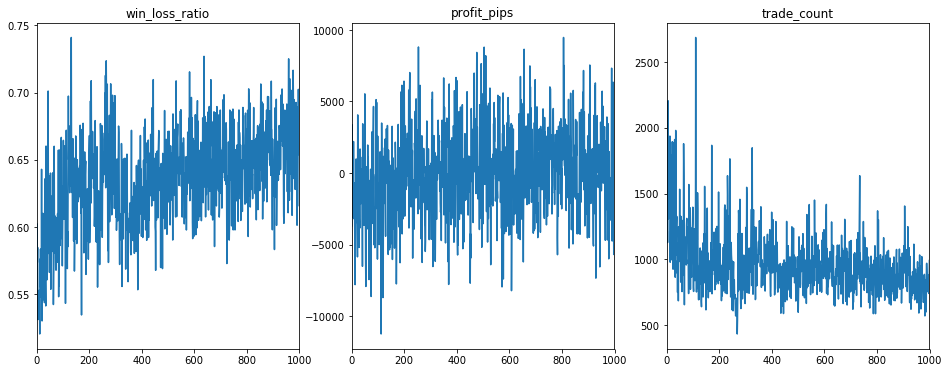

In [14]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [15]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['4h-EUR_USD.pkl']

## Test

In [16]:
# Uncomment to load agent from file 
# agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [17]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [18]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [19]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
test_results['account_drawdown_max_pips'] = test_results['account_drawdown_max'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))
print('Median win/loss ratio: {0}'.format(test_results['win_loss_ratio'].median()))
print('Median drawdown: {0} pips'.format(test_results['account_drawdown_max_pips'].median()))
print('Median trade count: {0}'.format(test_results['trade_count'].median()))
print('Trades per day: {0}'.format(test_results['trade_count'].median() / (test_data['date'].iloc[-1] - test_data['date'].iloc[0]).days))

Median profit: 1673.5749999996783 pips
Median win/loss ratio: 0.5040584522538905
Median drawdown: -753.250000000063 pips
Median trade count: 603.0
Trades per day: 0.33296521258972944


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a314cd0>]],
      dtype=object)

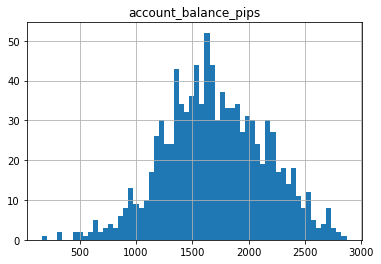

In [20]:
# Historgram of account balance
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1389c1210>]],
      dtype=object)

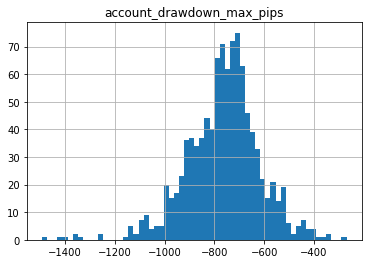

In [21]:
# Historgram of max drawdown
plt.figure(figsize=(16,6))
test_results.hist(column='account_drawdown_max_pips', bins=60)

## Analyse positions on test data

In [22]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [23]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [24]:
env._stats()

{'trade_count': 630,
 'win_loss_ratio': 0.5031746031746032,
 'account_balance': 0.13865999999996648,
 'unrealised_pl': -0.017554999999999987,
 'account_drawdown': -0.09083500000001932,
 'account_drawdown_max': -0.0930700000000193}

In [25]:
position_data = env.price_data.copy()

In [26]:
position_data['position'] = position_data['position'] - 1

In [27]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

632 positions to plot...


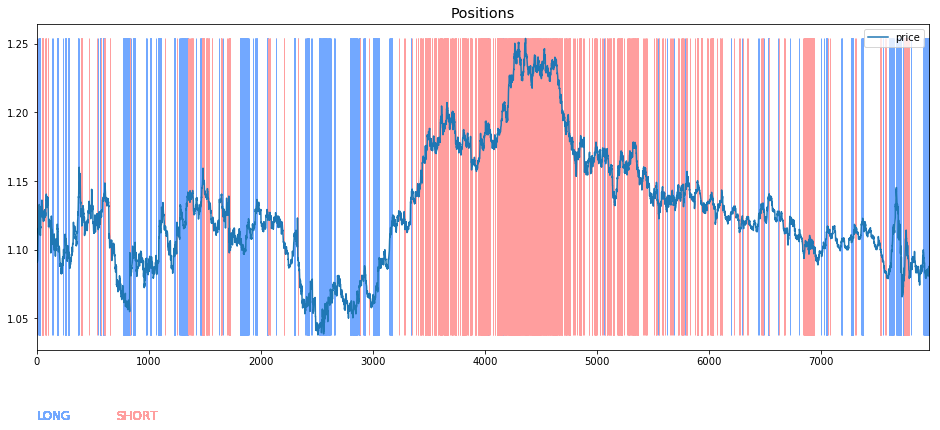

In [28]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [29]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 51.74%
Ratio of long to short positions: 0.34
Median profit: 0.0
Total profit: 0.1684299999999963
Median position length: 1.0
Number of trades: 632


In [30]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2015-05-29 12:00:00,1.09938,2015-05-29 16:00:00,1.09830,1,NaN,NaN,False,NaN
1,2015-06-02 12:00:00,1.11281,2015-06-03 04:00:00,1.11410,4,1.0,0.00129,True,0.00129
2,2015-06-03 08:00:00,1.11170,2015-06-03 16:00:00,1.12746,2,1.0,0.01576,True,0.01705
3,2015-06-03 16:00:00,1.12746,2015-06-04 00:00:00,1.12698,2,-1.0,0.00048,True,0.01753
4,2015-06-04 04:00:00,1.12592,2015-06-04 12:00:00,1.12700,2,1.0,0.00108,True,0.01861
...,...,...,...,...,...,...,...,...,...
627,2020-03-24 08:00:00,1.08652,2020-03-25 00:00:00,1.08094,4,1.0,-0.00558,False,0.18563
628,2020-03-25 00:00:00,1.08094,2020-04-03 08:00:00,1.07890,45,-1.0,0.00204,True,0.18767
629,2020-04-07 16:00:00,1.09048,2020-04-08 12:00:00,1.08641,5,1.0,-0.00407,False,0.18360
630,2020-04-30 16:00:00,1.09563,2020-05-01 16:00:00,1.09794,6,1.0,0.00231,True,0.18591


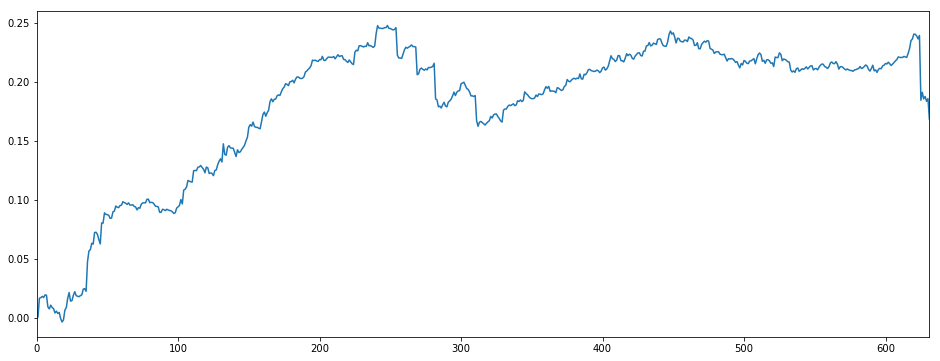

In [31]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.07834000000000108


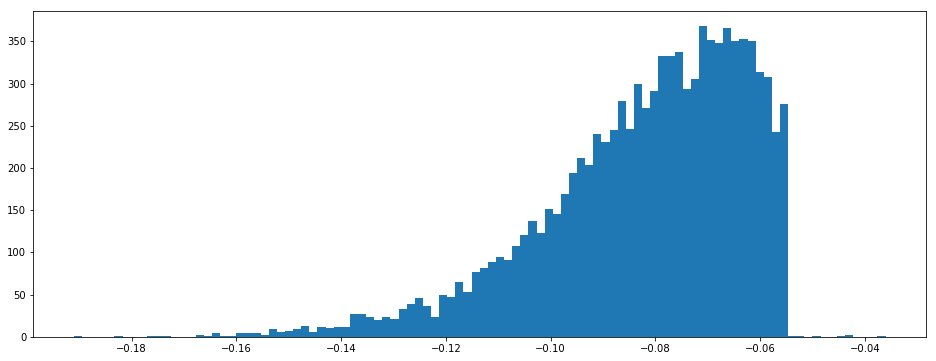

In [32]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);